In [ ]:
!git clone https://gitlab.com/lambda-hse/gans_coursera_public
%cd gans_coursera_public
from grading import Grader
parts = ['R2owU', 'ZNjxP']
grader = Grader('4BU4ADAjTWOxHb9Ewa9UZw', parts)

In [ ]:
COURSERA_EMAIL, COURSERA_TOKEN = ??? # PASTE YOUR COURSERA EMAIL AND ASSIGNMENT TOKEN HERE

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm


# Data

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms

from torch.utils.data import DataLoader

image_transforms = transforms.Compose([ # Augmentation
    transforms.RandomRotation(30),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # https://discuss.pytorch.org/t/understanding-transform-normalize/21730
    transforms.Normalize(mean=(0.1307, ), std=(0.3081, ))
        ])

cuda_num = 0 # CUDA DEVICE
batch_size = 128


In [ ]:
mnist_dataset = MNIST('./MNIST', train=True, transform=image_transforms, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


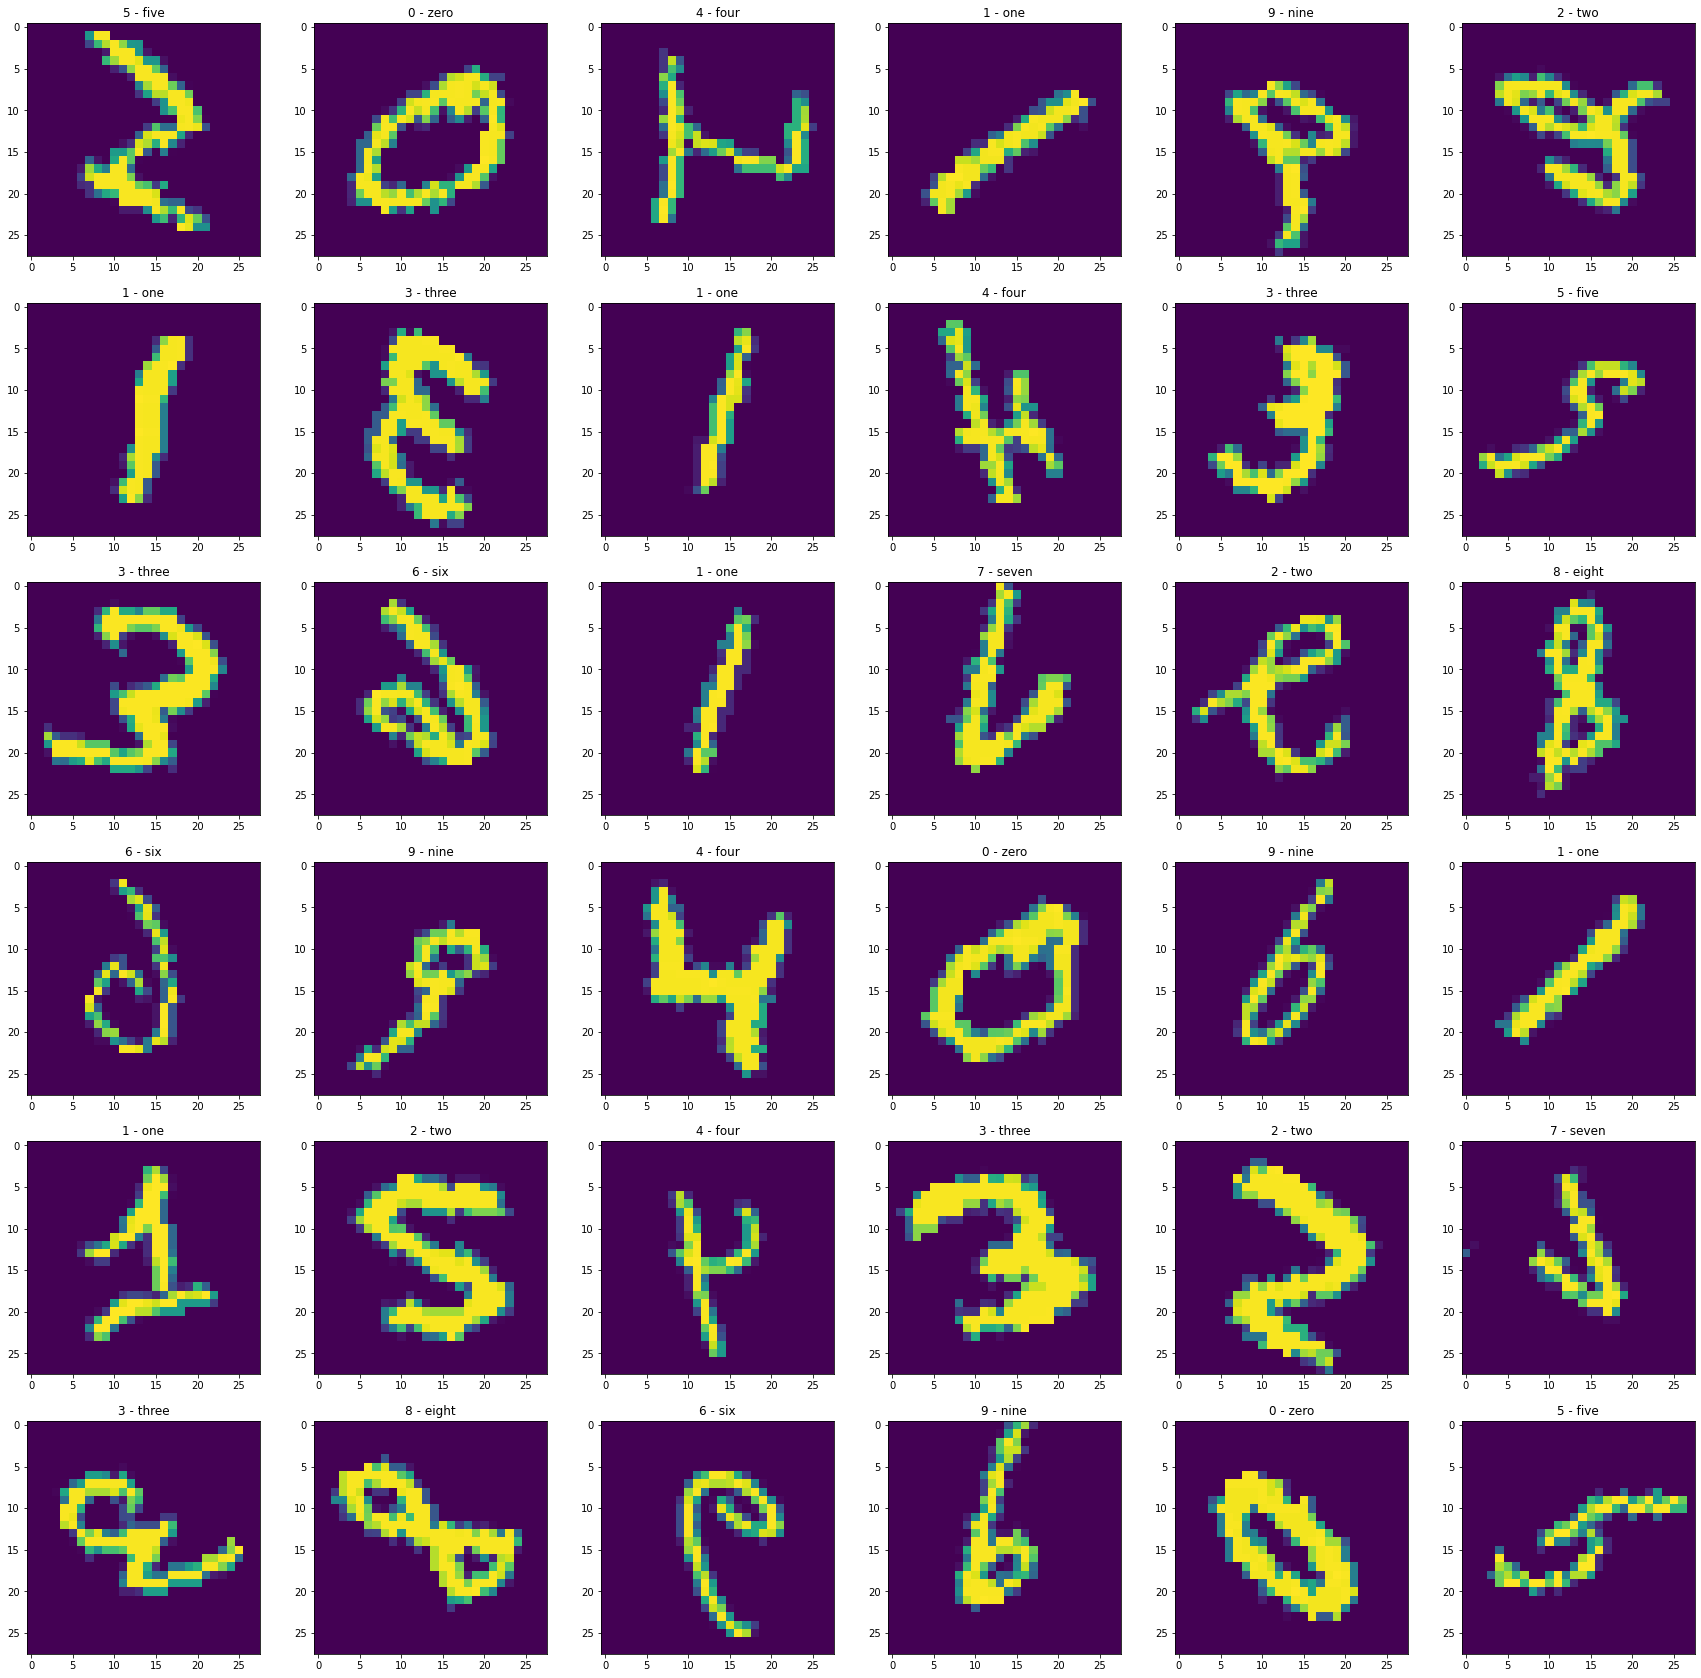

In [ ]:
def process_image(image):
    ### YOUR CODE HERE
    return ??? # numpy image with pixel values in [0, 1]

labels2name = {i: j for j, i in mnist_dataset.class_to_idx.items()}


plt.figure(figsize=(30, 30))
for ind, (image, label) in enumerate(mnist_dataset):
    if ind >= 6*6: break
    plt.subplot(6, 6, ind+1)
    plt.imshow(process_image(image))
    plt.title(labels2name[label])
plt.show()

# Define dataset for zeros only

In [ ]:
class OnlyZerosDataset(torch.utils.data.Dataset):
    ### MNIST subdataset with zero class only
    def __init__(self, mnist, transform=None):
        ??? # YOUR CODE HERE
    def __len__(self):
        return ??? # YOUR CODE HERE

    def __getitem__(self, index): # YOUR CODE HERE
        return ???

zeros_dataset = OnlyZerosDataset(mnist_dataset)
zeros_loader = DataLoader(zeros_dataset, batch_size=batch_size, drop_last=True)
assert(len(zeros_dataset) == 5923)

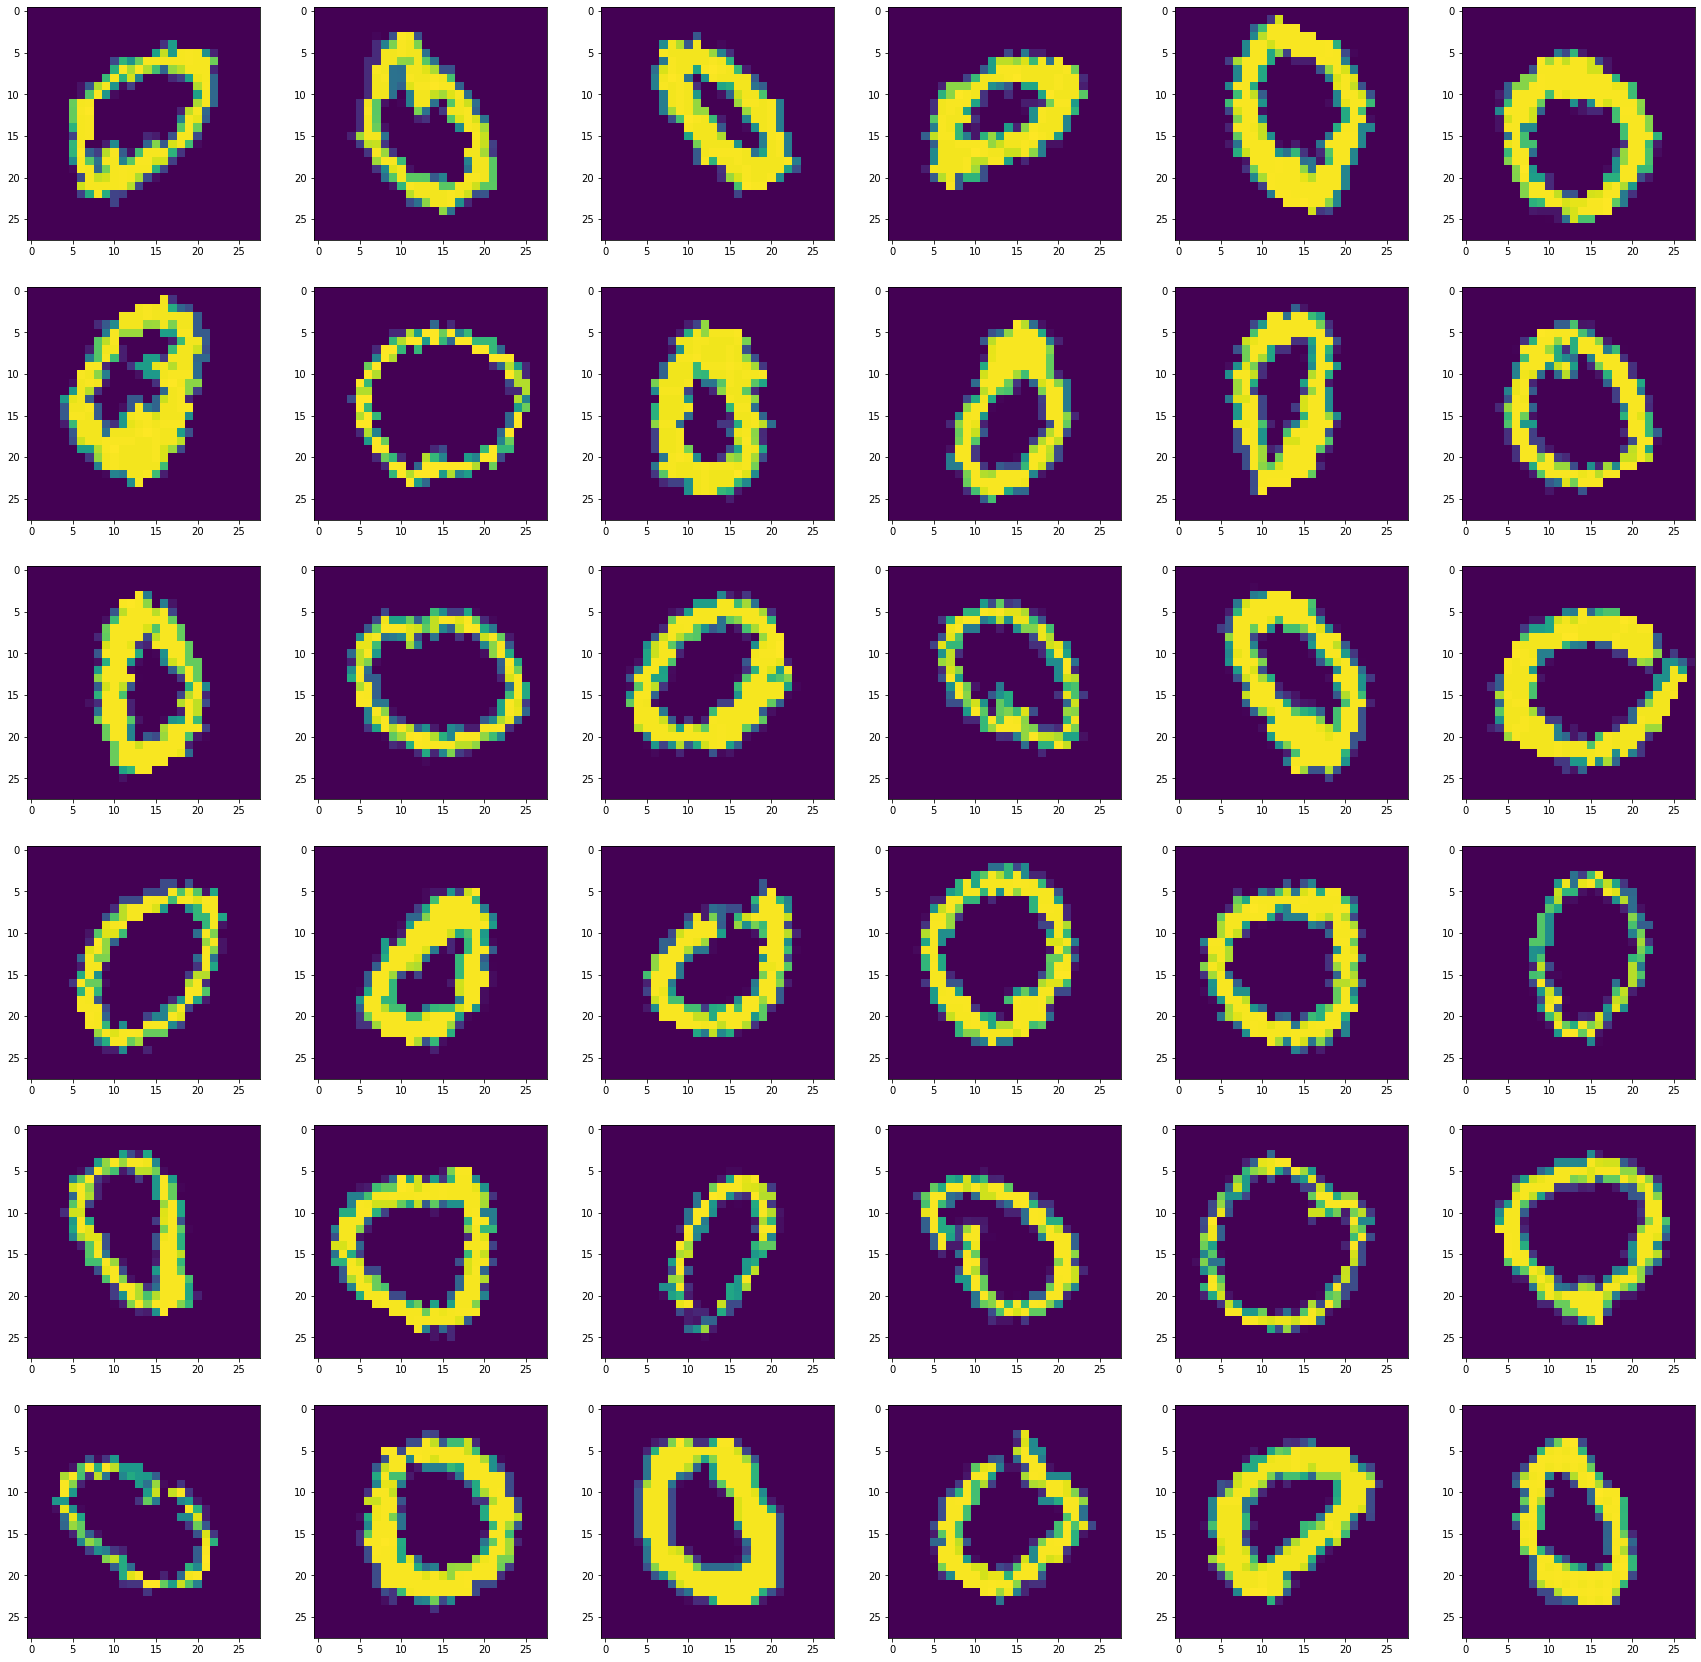

In [ ]:
plt.figure(figsize=(30, 30))
for ind, image in enumerate(zeros_dataset):
    if ind >= 6*6: break
    plt.subplot(6, 6, ind+1)
    plt.imshow(process_image(image))
plt.show()



![image](https://camo.githubusercontent.com/e43f336d6b83baf979de8ea558f34ccbe6713e1d/68747470733a2f2f6c696c69616e77656e672e6769746875622e696f2f6c696c2d6c6f672f6173736574732f696d616765732f47414e2e706e67)

***Generator*** takes noise as input and generates images in output

***Discriminator*** is standard binary classifier which takes image samples as input and returns determines whether these images are fake (generated, 1st class) or not (real, 2nd class)

In [ ]:
class Generator(nn.Module):
    # https://github.com/AKASHKADEL/dcgan-mnist/blob/master/networks.py
    # Define generator which takes random noise as input and generates image as output
    def __init__(self, nc=1, nz=100, ngf=32):
      self.nz = nz
      super(Generator, self).__init__()
      self.network = ??? # YOUR CODE HERE

    def forward(self, size):
      output = self.network(torch.randn(size, self.nz, 1, 1, device=self.device))
      return output

    @property
    def device(self):
      return next(self.parameters()).device

class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=32):
        super(Discriminator, self).__init__()
        # Define binary classifier which discriminates real image from generated
        self.network = ??? # YOUR CODE HERE
    def forward(self, input):
        return ??? # YOUR CODE HERE

In [ ]:
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'

generator = Generator().to(device)
discriminator = Discriminator().to(device)


# Weights initialization is very important! Use it to initialize weights for your networks
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

[model.apply(weights_init) for model in [generator, discriminator]] # initialize weights

optimizators = {
    'G': torch.optim.AdamW(generator.parameters(), lr=2e-4),
    'D': torch.optim.AdamW(discriminator.parameters(), lr=2e-4),
}

losses = {
    'D': [],
    'G': []
}

steps_ratio = 1 # ratio between gradient steps of generator and generator

In [ ]:
for epoch in tqdm(range(300)):
    for batch_idx, images in enumerate(zeros_loader):
        # train D

        ??? # YOUR CODE HERE. Fit discriminator on real and generated images

        # Hint: use torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1) # gradient clipping for stable convergence


        losses['D'].append(loss.item())
        # don't forget to use item

        if batch_idx % steps_ratio == 0:
          # train G
          ??? # YOUR CODE HERE. Fit generator to "fool" discriminator (Make the discriminator to classify generated images as real ones)
            # Hint: use torch.nn.utils.clip_grad_norm_(generator.parameters(), 1) # gradient clipping for stable convergence

          for _ in range(steps_ratio):
            losses['G'].append(loss.item())

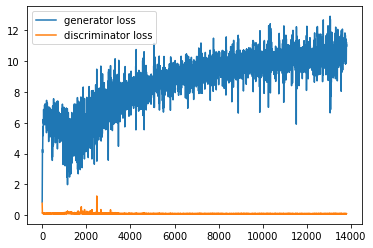

In [ ]:
plt.plot(losses['G'], label='generator loss')
plt.plot(losses['D'], label='discriminator loss')
plt.legend()
plt.show()

## Question
Epain what does it mean?

Plot another one to see discriminator loss better

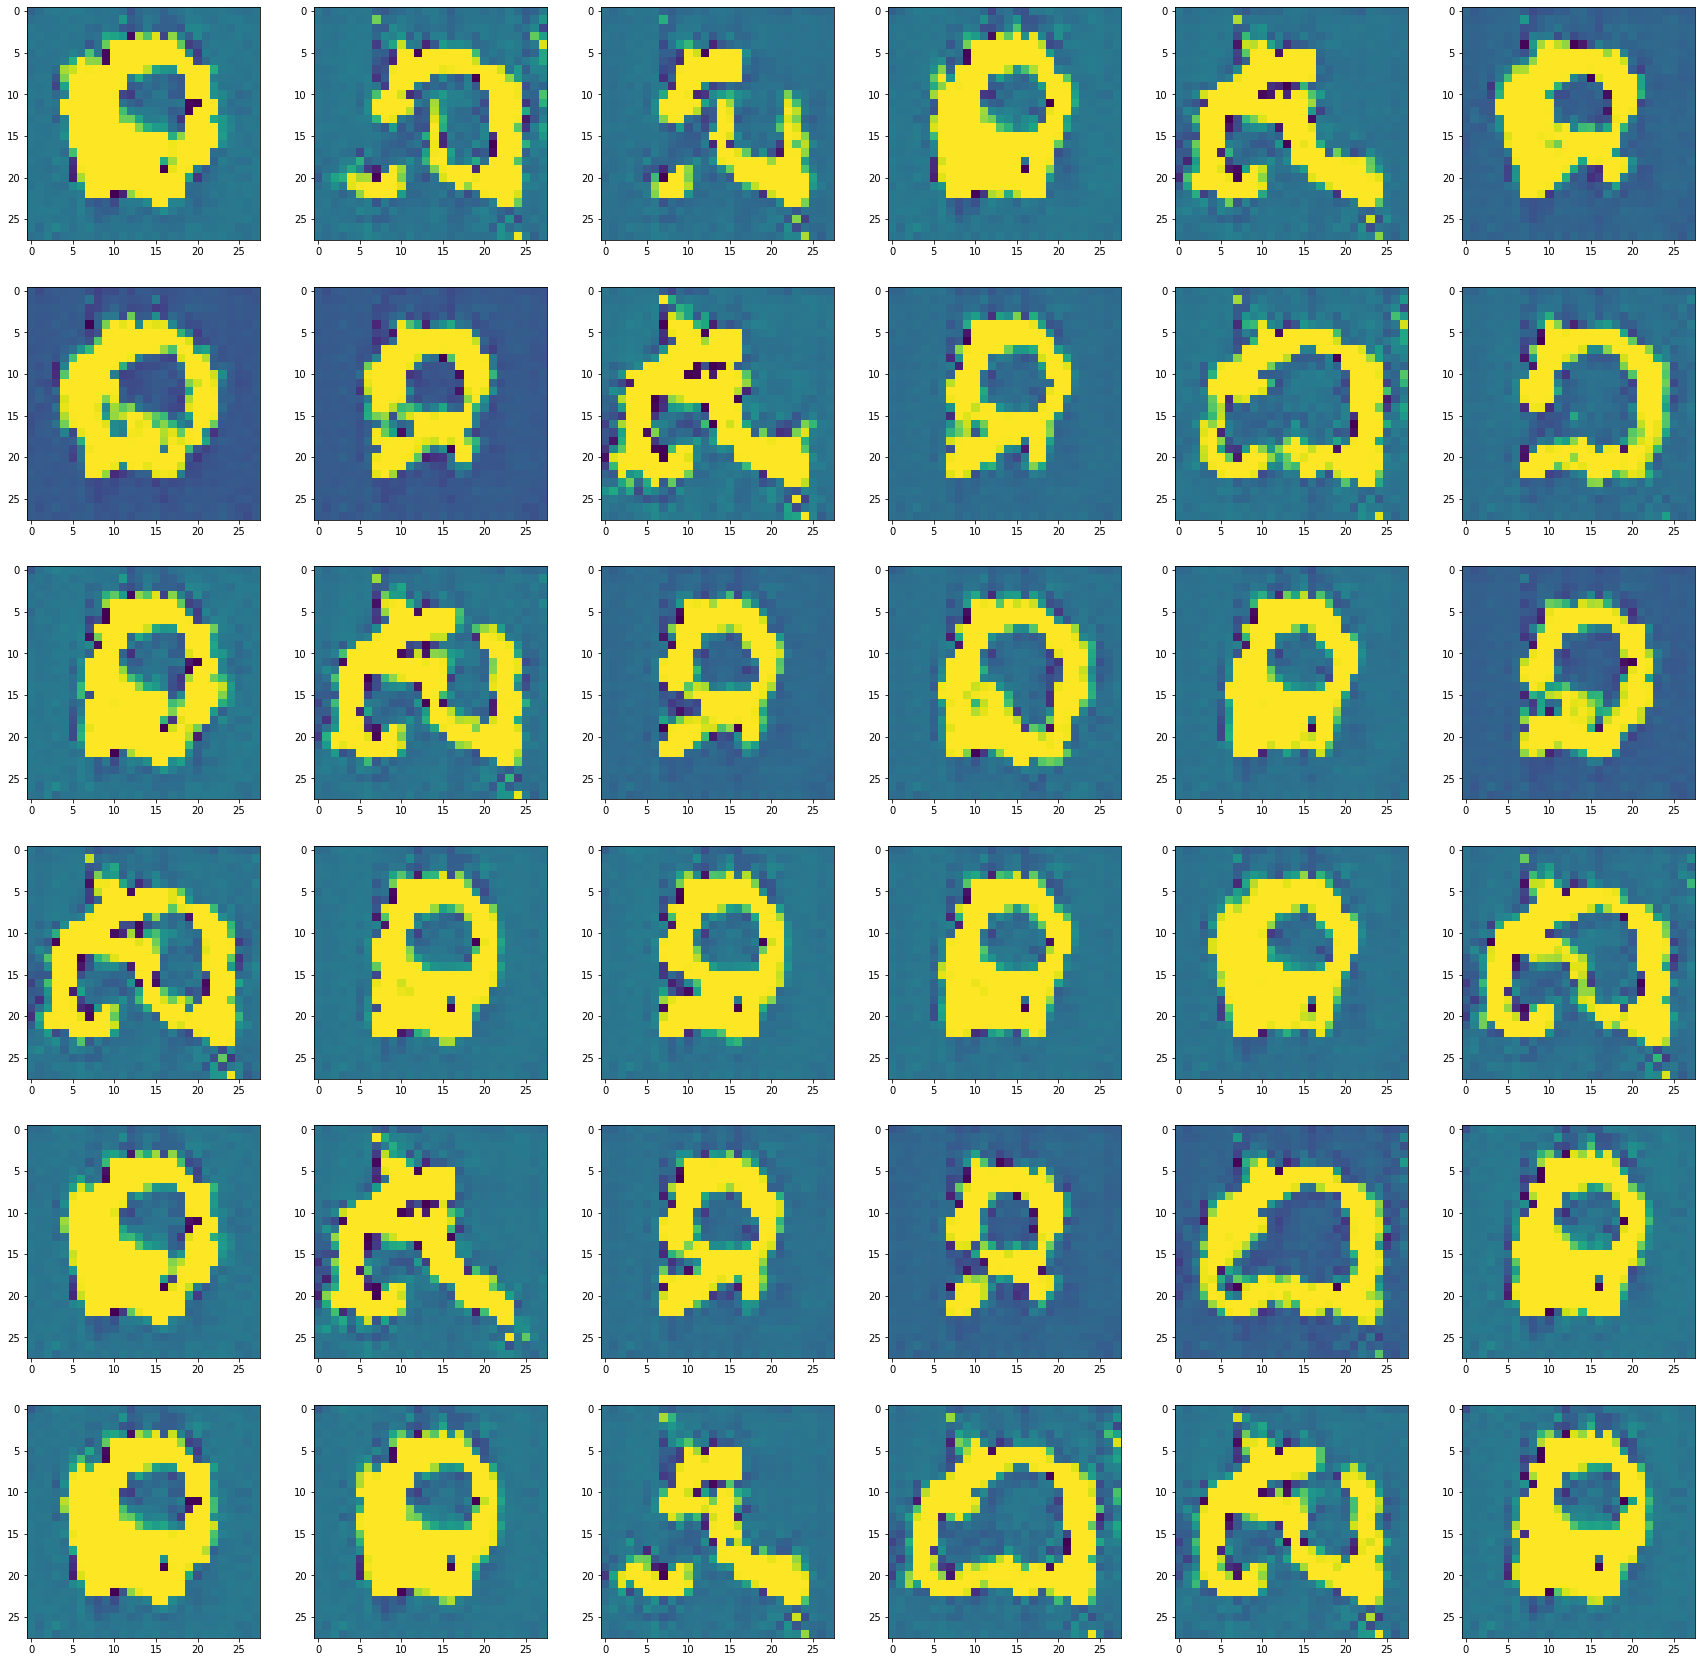

In [ ]:
generated = generator(36).detach().to('cpu')

plt.figure(figsize=(30, 30))
for ind, image in enumerate(generated):
    plt.subplot(6, 6, ind+1)
    plt.imshow(process_image(image))
plt.show()

In [ ]:
## GRADED PART, DO NOT CHANGE!

!pip install lpips

import seaborn as sns
import lpips
# define as a criterion module (recommended)
loss_fn_vgg = lpips.LPIPS(net='vgg')

dists = []
for image in tqdm(zeros_loader):
  with torch.no_grad():
    generated = generator(images.shape[0]).detach().to('cpu')
    for d in loss_fn_vgg(generated, images.to('cpu')).squeeze().detach().numpy().tolist(): # measure distances between real and generated images
      dists.append(d)

     |████████████████████████████████| 61kB 9.1MB/s 
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


## Task
plot a histogram for dists and round_dists

#Conditional GAN
Task: train Conditional GAN in CIFAR10 dataset

In [ ]:
from torchvision.datasets import CIFAR10
from torchvision import transforms

from torch.utils.data import DataLoader

image_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    # https://discuss.pytorch.org/t/understanding-transform-normalize/21730
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
cifar_dataset = CIFAR10('./CIFAR10', train=True, transform=image_transforms, download=True)
cifar_loader = DataLoader(cifar_dataset, batch_size=64, drop_last=True)

Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10


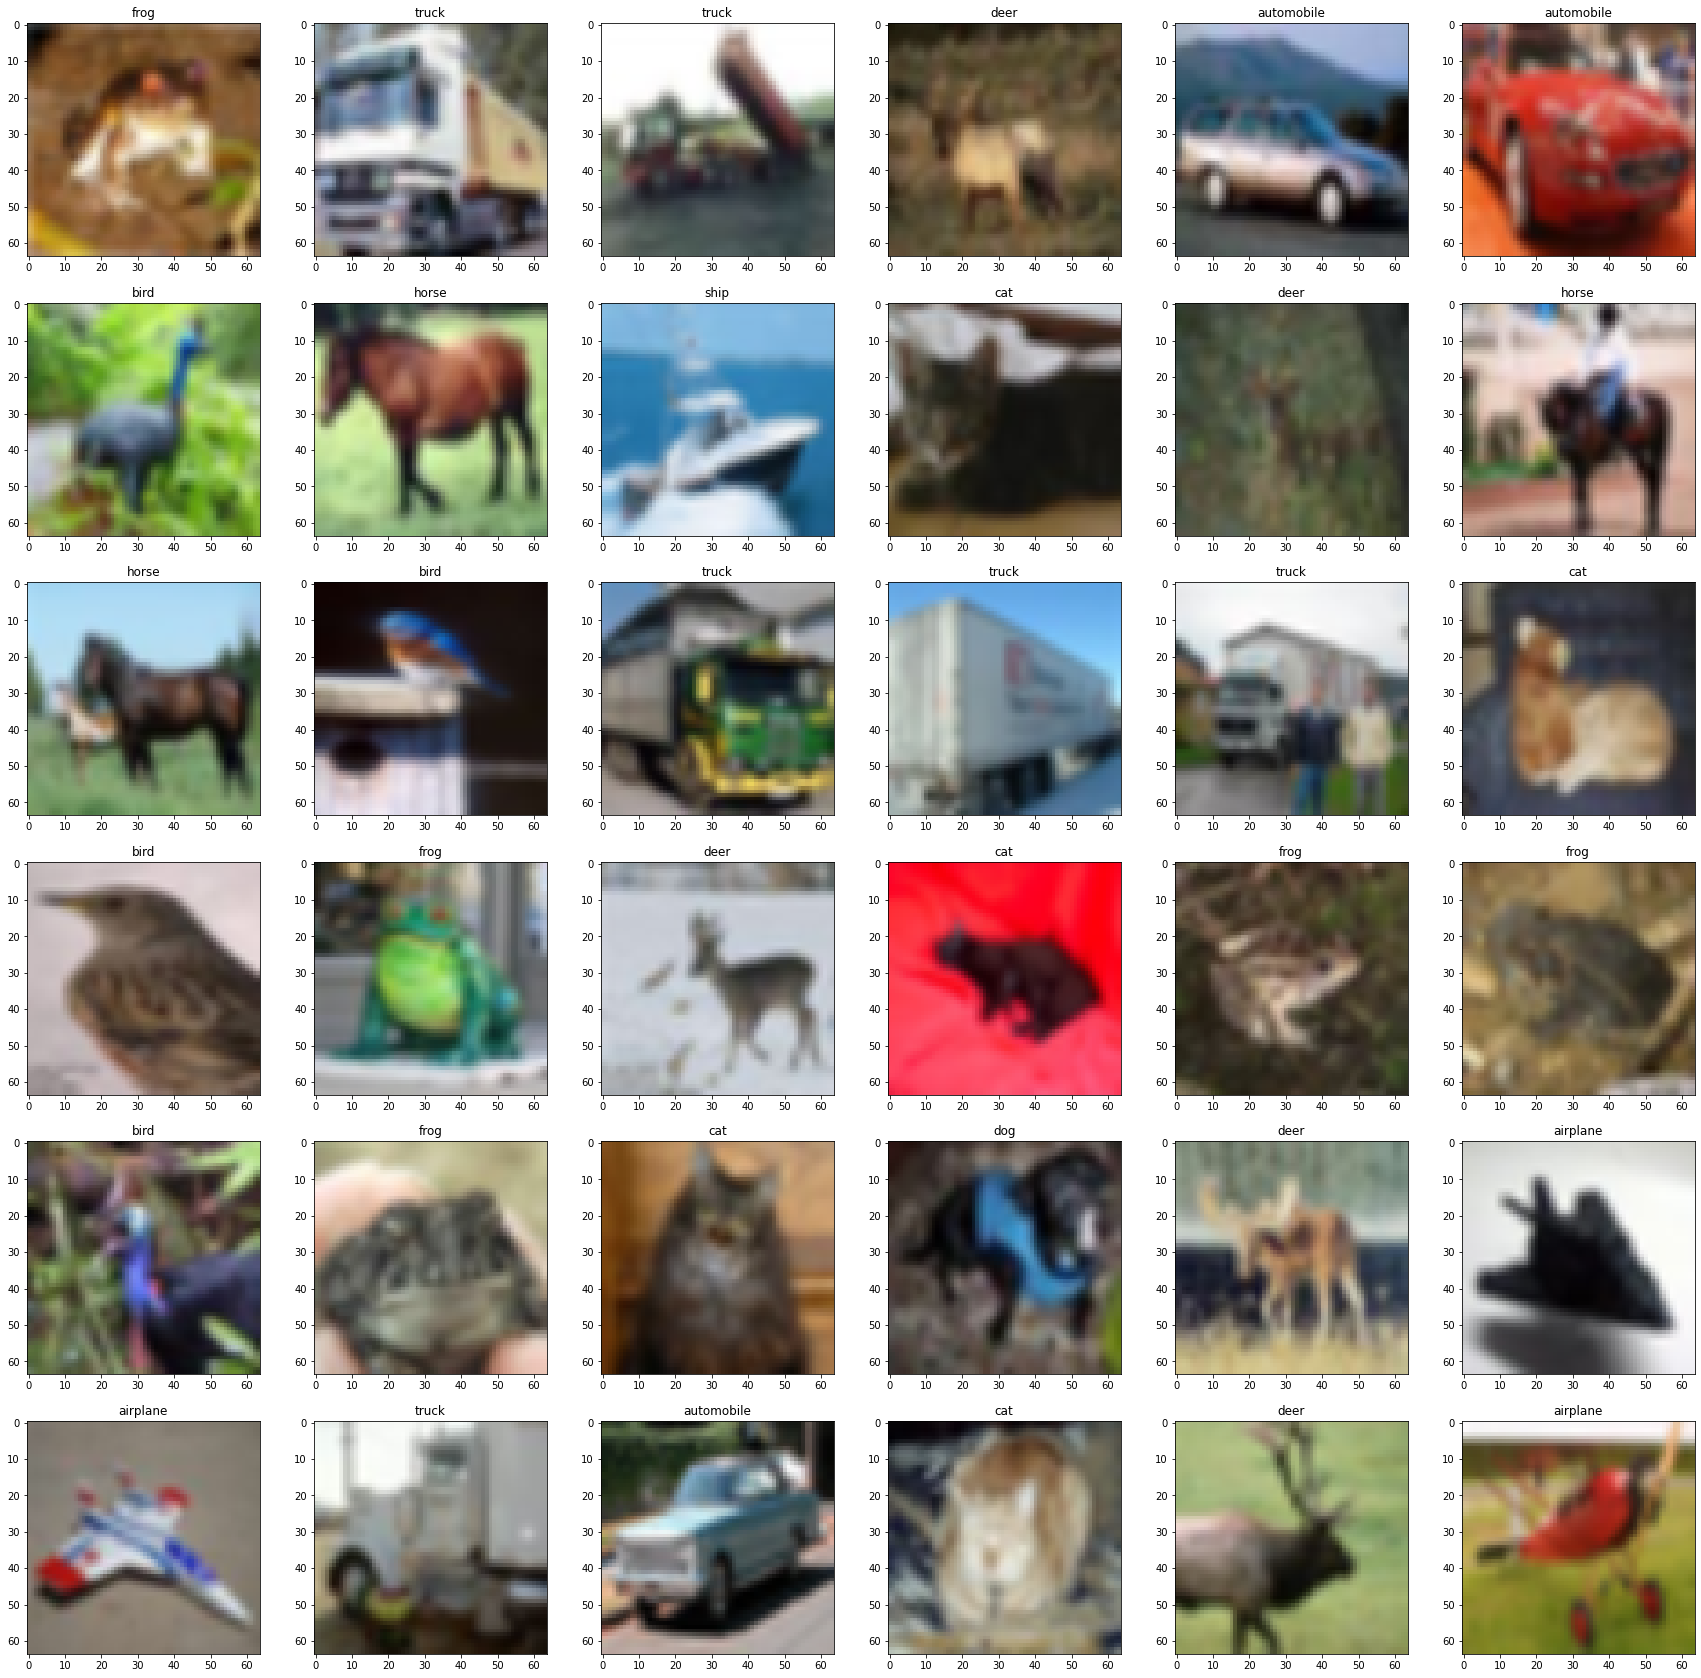

In [ ]:
def process_image(image):
    ### YOUR CODE HERE
    return ??? # numpy image with pixel values in [0, 1]


labels2name = {i: j for j, i in cifar_dataset.class_to_idx.items()}


plt.figure(figsize=(30, 30))
for ind, (image, label) in enumerate(cifar_dataset):
    if ind >= 6*6: break
    plt.subplot(6, 6, ind+1)
    plt.imshow(process_image(image))
    plt.title(labels2name[label])
plt.show()

In [ ]:
# https://github.com/lt911/Experiment_with_conditional_DCGAN/blob/master/cdcgan.py

class Generator(nn.Module):
    def __init__(self, nc=3, ngf=64, nz=100, embsize=10):
        super(Generator, self).__init__()
        # Define generator which takes random noise with class embeddings of size :param embsize as input and generates image as output
        ??? # YOUR CODE HERE

    def forward(self, c):
        return ??? # YOUR CODE HERE

    @property
    def device(self):
      return next(self.parameters()).device

class Discriminator(nn.Module):
    def __init__(self, ndf=64, ngf=64, nc=3, embsize=10):
        super(Discriminator, self).__init__()
        ??? # YOUR CODE HERE. Define discriminator which takes image with class embeddings as input and returns class (0 for generated images and 1 for real ones)

    def forward(self, input, c):
        ??? # YOUR CODE HERE

In [ ]:
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'

n_classes = 10
from sklearn.preprocessing import LabelBinarizer
emb = LabelBinarizer().fit(range(n_classes)) # Label binarizer is used to convert class label to class embeddings

generator = Generator(embsize=n_classes).to(device)
discriminator = Discriminator().to(device)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

[model.apply(weights_init) for model in [generator, discriminator]] # initialize weights

optimizators = {
    'G': torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.9, 0.999)),
    'D': torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.9, 0.999)),
}

losses = {
    'D': [],
    'G': []
}

steps_ratio = 1 # ratio between gradient steps of generator and generator

In [ ]:
for epoch in tqdm(range(100)):
    for batch_idx, (images, classes) in enumerate(cifar_loader):
        # train D

        ??? # YOUR CODE HERE. Fit discriminator on real and generated images

        # Hint: use torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1) # gradient clipping for stable convergence


        losses['D'].append(loss.item())
        # don't forget to use item

        if batch_idx % steps_ratio == 0:
          # train G
          ??? # YOUR CODE HERE. Fit generator to "fool" discriminator (Make the discriminator to classify generated images as real ones)
            # Hint: use torch.nn.utils.clip_grad_norm_(generator.parameters(), 1) # gradient clipping for stable convergence

          for _ in range(steps_ratio):
            losses['G'].append(loss.item())

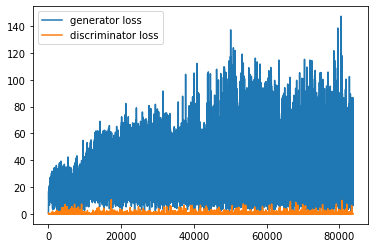

In [ ]:
plt.plot(losses['G'], label='generator loss')
plt.plot(losses['D'], label='discriminator loss')
plt.legend()
plt.show()

## Question
Epain what does it mean?

Plot another one to see discriminator loss better

In [ ]:
for batch_idx, (images, labels) in enumerate(cifar_loader):
    images = images.to(device)
    classes = torch.from_numpy(emb.transform(labels.numpy())).type(torch.FloatTensor).view(-1, n_classes, 1, 1).to(device)

    batch_size = images.shape[0]
    with torch.no_grad():
      fake_images = generator(classes) # Generate images
    break;

plt.figure(figsize=(30, 30))
for ind in range(fake_images.shape[0]):
    image = fake_images[ind]
    plt.subplot(8, 8, ind+1)
    plt.imshow(process_image(image))
    plt.title(labels2name[labels[ind].item()])
plt.show()

In [ ]:
## GRADED PART, DO NOT CHANGE!

test_fn = lpips.LPIPS(net='vgg')
distances = []

# try with different num_test_steps to try best one
num_test_steps = [# your items]


for batch_idx, (images, labels) in tqdm(enumerate(cifar_loader), total=num_test_steps):
    if batch_idx > num_test_steps: break;
    images = images.to(device)
    classes = torch.from_numpy(emb.transform(labels.numpy())).type(torch.FloatTensor).view(-1, n_classes, 1, 1).to(device)

    batch_size = images.shape[0]
    with torch.no_grad():
      generated = generator(classes) # Generate images
    for d in test_fn(generated.to('cpu'), images.to('cpu')).squeeze().detach().numpy().tolist(): # measure distances between real and generated images
      distances.append(d)


grader.set_answer(parts[1], np.mean(distances))

## Task
plot a histogram for dists and round_dists with each num_test_steps

In [ ]:
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
